In [2]:
import cv2
import mediapipe as mp
import os
from matplotlib import pyplot as plt
import time
import numpy as np
import pyttsx3
import time
import speech_recognition as sr
import pyttsx3


In [3]:
#pip install pyttsx3
#pip install pyaudio

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic=mp.solutions.holistic

In [5]:
#Hand Detection
def mediapipe_hand_Detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False  
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [6]:
def draw_hand_style_landmarks(image, results):
    
    # Draw face connections
   # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
   #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
     #                        ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
#Read frame from camera
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        ret,frame=cap.read()
        #Prediction
        image,results=mediapipe_hand_Detection(frame,holistic)
        
        #Landmarks
        draw_hand_style_landmarks(image,results)
        
        cv2.imshow('Raw Webcamp Feed',image)

        if cv2.waitKey(10) & 0xFF == ord ('q'):
            break

    cap.release()
    cv2.destroyAllWindows()   

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,lh, rh])

In [9]:
result_test = extract_keypoints(results)

In [10]:
#result_test

In [11]:
len(result_test)

258

In [12]:
#Folder Path
DATA_PATH =os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello', 'Where', 'hospital','thankyou'])

#No of video
no_sequences = 20

# Frame in each video
sequence_length = 30

In [13]:
for action in actions:
    for sequence in range(no_sequences):   
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

In [14]:
print(os.getcwd())

C:\Users\user\Computer Vision


In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_hand_Detection(frame, holistic)

                # Draw landmarks
                draw_hand_style_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [15]:
#Pre-process Data
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [16]:
label_map={label:num for num,label in enumerate(actions)}

In [17]:
label_map

{'hello': 0, 'Where': 1, 'hospital': 2, 'thankyou': 3}

In [18]:
DATA_PATH

'MP_Data'

In [19]:
sequences, labels = [], []
for action in actions:
    print(action)
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

hello
Where
hospital
thankyou


In [20]:
np.array(sequences).shape

(80, 30, 258)

In [21]:
X = np.array(sequences)

In [22]:
np.array(labels).shape

(80,)

In [23]:
y = to_categorical(labels).astype(int)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [25]:
X_test.shape

(4, 30, 258)

In [29]:
#LSTM Algorithm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [30]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [31]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [32]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 5s 347ms/step - loss: 1.3559 - categorical_accuracy: 0.3553
Epoch 2/200
3/3 [==============================] - 0s 85ms/step - loss: 1.1952 - categorical_accuracy: 0.3684
Epoch 3/200
3/3 [==============================] - 0s 87ms/step - loss: 1.0416 - categorical_accuracy: 0.4342
Epoch 4/200
3/3 [==============================] - 0s 80ms/step - loss: 0.9916 - categorical_accuracy: 0.4211
Epoch 5/200
3/3 [==============================] - 0s 84ms/step - loss: 0.9945 - categorical_accuracy: 0.4211 0s - loss: 1.0311 - categorical_accuracy: 0.
Epoch 6/200
3/3 [==============================] - 0s 78ms/step - loss: 0.9328 - categorical_accuracy: 0.5000
Epoch 7/200
3/3 [==============================] - 0s 81ms/step - loss: 0.8645 - categorical_accuracy: 0.5263
Epoch 8/200
3/3 [==============================] - 0s 82ms/step - loss: 0.8677 - categorical_accuracy: 0.6579
Epoch 9/200
3/3 [==============================] - 0s 78ms/step - loss: 0.

3/3 [==============================] - 0s 90ms/step - loss: 0.0647 - categorical_accuracy: 0.9868
Epoch 75/200
3/3 [==============================] - 0s 82ms/step - loss: 0.0536 - categorical_accuracy: 0.9868
Epoch 76/200
3/3 [==============================] - 0s 83ms/step - loss: 0.0411 - categorical_accuracy: 1.0000
Epoch 77/200
3/3 [==============================] - 0s 84ms/step - loss: 0.0464 - categorical_accuracy: 1.0000
Epoch 78/200
3/3 [==============================] - 0s 91ms/step - loss: 0.0226 - categorical_accuracy: 1.0000
Epoch 79/200
3/3 [==============================] - 0s 87ms/step - loss: 0.1143 - categorical_accuracy: 0.9605
Epoch 80/200
3/3 [==============================] - 0s 79ms/step - loss: 2.7001 - categorical_accuracy: 0.7500
Epoch 81/200
3/3 [==============================] - 0s 74ms/step - loss: 1.9046 - categorical_accuracy: 0.6579
Epoch 82/200
3/3 [==============================] - 0s 81ms/step - loss: 0.4762 - categorical_accuracy: 0.7500
Epoch 83/200
3

3/3 [==============================] - 0s 76ms/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 148/200
3/3 [==============================] - 0s 86ms/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 149/200
3/3 [==============================] - 0s 80ms/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 150/200
3/3 [==============================] - 0s 80ms/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 151/200
3/3 [==============================] - 0s 81ms/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 152/200
3/3 [==============================] - 0s 84ms/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 153/200
3/3 [==============================] - 0s 83ms/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 154/200
3/3 [==============================] - 0s 83ms/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 155/200
3/3 [==============================] - 0s 79ms/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            82688     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 237,284
Trainable params: 237,284
Non-trainable params: 0
__________________________________________________

In [96]:
model.save('action.h5')

In [97]:
res = model.predict(X_test)

In [98]:
res

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.0257144e-20, 1.0413079e-08, 1.0000000e+00, 1.4997923e-08],
       [1.0000000e+00, 4.8951387e-13, 0.0000000e+00, 9.7435222e-32]],
      dtype=float32)

In [101]:
actions[np.argmax(res[0])]

'thankyou'

In [36]:
from tensorflow.keras.applications import imagenet_utils
#del model
#model.save('action.hdf5')


In [37]:
#del model

In [38]:
model.load_weights('action.h5')

In [39]:
#Confusion Matrix and accuracy
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [41]:
yhat = model.predict(X_test)

In [42]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [43]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 2]],

       [[3, 0],
        [0, 1]],

       [[3, 0],
        [0, 1]]], dtype=int64)

In [44]:
accuracy_score(ytrue, yhat)

1.0

In [45]:
#Test in Real Time
colors = [(245,117,16), (117,245,16), (16,117,245),(16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        print(num,prob)
        cv2.rectangle(output_frame, (0,60+num*40),(int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [46]:
#plt.figure(figsize=(10,10))
#actions = np.array(['hello', 'Where', 'hospital'])
#plt.imshow(prob_viz(res, actions, image, colors))

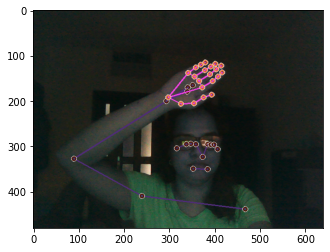

In [47]:
plt.imshow(image)

In [48]:
 # Function to convert text to
            # speech
def SpeakText(command):
# Initialize the engine
    engine = pyttsx3.init()
    engine.say(command)
    engine.runAndWait()

In [49]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_hand_Detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_hand_style_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
            #Convert Text to Sound
            engine=pyttsx3.init()
            saying=actions[np.argmax(res)]
            engine.say(saying)
            time.sleep(1)
            engine.runAndWait()
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
0 1.482667e-05
1 0.0019622657
2 0.093220055
3 0.90480286
<class 'mediapipe.python.solution_base.SolutionOutputs'>
0 3.846255e-22
1 1.5403849e-18
2 0.00011025167
3 0.99988973
<class 'mediapipe.python.solution_base.SolutionOutputs'>
0 1.3752618e-20
1 5.118269e-17
2 0.008560406
3 0.9914396
<class 'mediapipe.python.solution_base.SolutionOutputs'>
0 3.8339536e-15
1 1.598795e-10
2 0.9996088
3 0.00039117306
<class 'mediapipe.python.solution_base.SolutionOutputs'>
0 2.0206551e-12
1 5.8213004e-06
2 0.9999939
3 2.619956e-07
<class 'mediapipe.python.solution_base.SolutionOutputs'>
0 2.733957e-13
1 7.535468e-08
2 0.9999964
3 3.5440808e-06


In [ ]:
        # Initialize the recognizer
        r = sr.Recognizer()
        
        #while(1):
        try:
		# use the microphone as source for input.
            with sr.Microphone() as source2:
                
                r.adjust_for_ambient_noise(source2, duration=0.2)
			#listens for the user's input
                audio2 = r.listen(source2)
			# Using google to recognize audio
                MyText = r.recognize_google(audio2)
                MyText = MyText.lower()

                print("Did you say "+MyText)
                SpeakText(MyText)

        except sr.RequestError as e:
                print("Could not request results; {0}".format(e))

        except sr.UnknownValueError:
                print("unknown error occured")

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

In [ ]:
np.version.version
from platform import python_version
print(python_version())
import tensorflow as tf
print(tf. __version__) 

In [57]:
def test_different_voices(test_str,num_voices,speech_engine):
    voices=speech_engine.getProperty('voices')
    idx_found=-1
    if num_voices > len(voices):
        num_voices=len(voices)
        
    
    for idx,voice in enumerate(voices[:num_voices]):
        speech_engine.setProperty('voice',voice.id)
        cur_voice=[val for val in speech_engine.getProperty('voices') if val.id==voice.id][0]
        voice.welcome=f'I my name is {cur_voice.name}'
        engine.say(voice.welcome + test_str)

In [62]:
#pip install speechrecognition

In [73]:
# Python program to translate
# speech to text and text to speech


import speech_recognition as sr
import pyttsx3

# Initialize the recognizer
r = sr.Recognizer()

# Function to convert text to
# speech
def SpeakText(command):
	
	# Initialize the engine
	engine = pyttsx3.init()
	engine.say(command)
	engine.runAndWait()
	
	
# Loop infinitely for user to
# speak

while(1):
    
	
	# Exception handling to handle
	# exceptions at the runtime
	try:
		
		# use the microphone as source for input.
		with sr.Microphone() as source2:
            
            
			
			# wait for a second to let the recognizer
			# adjust the energy threshold based on
			# the surrounding noise level
			r.adjust_for_ambient_noise(source2, duration=0.2)
			
			#listens for the user's input
			audio2 = r.listen(source2)
			
			# Using google to recognize audio
			MyText = r.recognize_google(audio2)
			MyText = MyText.lower()

			print("Did you say "+MyText)
			SpeakText(MyText)
			
	except sr.RequestError as e:
		print("Could not request results; {0}".format(e))
		
	except sr.UnknownValueError:
		print("unknown error occured")


unknown error occured
Did you say hello


KeyboardInterrupt: 